<a href="https://colab.research.google.com/github/victor-armegioiu/Learning-Bayesian-Priors/blob/main/Prior_as_Particles_(SVGD_for_posterior_training).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Better priors represented as particles

## Setup 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# gpflow doesn't come preloaded with colab.
!pip3 install gpflow

In [60]:
import numpy as np
import time

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib
import matplotlib.pyplot as plt

from gdrive.MyDrive.prior_learning.spectral_stein_grad.estimator import SpectralScoreEstimator
from gdrive.MyDrive.prior_learning import data_utils
from gdrive.MyDrive.prior_learning import prior_utils
from gdrive.MyDrive.prior_learning import sliced_score_estimation
from gdrive.MyDrive.prior_learning import svgd


tf.compat.v1.enable_eager_execution()


In [5]:
tf.executing_eagerly()

True

In [6]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Building the dataset

In [7]:
task_count = 10
tasks_data = data_utils.GetSinusoidParams(task_count)

In [8]:
config = {
          'input_shape': 1,             # Shape of input data.
          'size': 5,                    # Number of samples per task.  
          'generation_method': 'sine',  # Generating process of the labels.
          'tasks_data': tasks_data,     # Hyperparams for the sinusoids.
}

In [9]:
X, y = data_utils.GetDataset(config)
X = X[:, None]
test_tasks_cnt = 1

first_test_idx = len(X) - test_tasks_cnt * config['size']
X_train, y_train = X[:first_test_idx], y[:first_test_idx]
X_test, y_test = X[first_test_idx:], y[first_test_idx:]

In [10]:
X_train.shape, X_test.shape

((45, 1), (5, 1))

In [11]:
scaler = StandardScaler().fit(X_train)

In [12]:
# Use the same scaler in order to ensure that we don't inject knowledge
# about the test distribution in our training biases.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

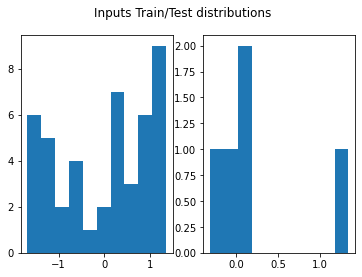

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Inputs Train/Test distributions')
ax1.hist(X_train, bins=10)
ax2.hist(X_test, bins=10)
plt.show()

In [14]:
# Scale both dataset by `y_train_max`. Same reasoning
# as in using the same scaler on inputs. This is done to avoid
# exploding gradients.
y_train_max = y_train.max()
y_train /= y_train_max
y_test /= y_train_max

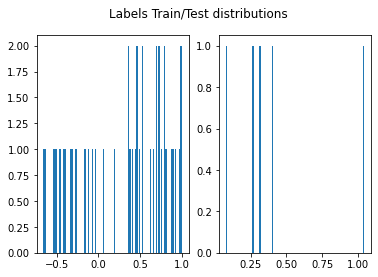

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Labels Train/Test distributions')
ax1.hist(y_train, bins=100)
ax2.hist(y_test, bins=100)
plt.show()

## GP Prior Setup

Train a $\mathcal{GP}$ on the training data, so that we may later use the tuned kernel for estimating the covariance of a Normal distribution over function values (this shall be used as the prior in the `f-bnn` formulation below).

In [16]:
# Pre-train GP prior.
gp_prior, _ = prior_utils.TrainGPPrior(X_train, y_train)

## Sliced Score Estimator Setup (https://arxiv.org/pdf/1905.07088.pdf)

Here we train a network $h(\cdot, \hat{\theta})$ which minimizes the objective $\mathbb{E}_{x \sim \mu} \Vert h(x, \hat{\theta}) - \nabla_x \log p(x) \Vert_{2}$ in an unsupervised way, where $\mu$ is some unknown data generating process and $p := \sum_i \delta_{x_i}$ is an empirical measure represented as a set of particles.

In [18]:
input_shape = (1,)
score_net = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape, name='input'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(input_shape[0]),
])

config_slice_train = {'data': y_train[:, None],
          'score_net': score_net,
          'epochs': 100, 
          'lambda_reg': 0.15
}

In [19]:
score_net, best_loss = (
    sliced_score_estimation.GetSlicedScoreEstimator(config_slice_train,
                                                    verbose=True))

Epoch [0], loss: [5.358446]
Epoch [10], loss: [2.604599]
Epoch [20], loss: [0.484551]
Epoch [30], loss: [-0.614255]
Epoch [40], loss: [-2.555415]
Epoch [50], loss: [-2.209540]
Epoch [60], loss: [-4.879505]
Epoch [70], loss: [-4.139803]
Epoch [80], loss: [-5.332477]
Epoch [90], loss: [-5.571452]


## Model setup

In [22]:
# Estimator to be used for computing score gradients of implicit distributions
# represtend as sets of particles.
estimator = SpectralScoreEstimator(n_eigen_threshold=0.99, eta=0.0)

In [24]:
# An ensemble of these models will represent our set of particles.
def GetLinearModel():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(5, input_shape=(1,), activation='relu'))
  model.add(tf.keras.layers.Dense(1))
  return model

Reframing variational inference in the function space, we arrive at the following objective formulation [Sun et al., 2019]

\begin{equation}
 \log p(\mathcal{D} \vert f) - \lambda KL(q \Vert p) \hspace{0.5cm}(1)
\end{equation}

where $q, p$ represent the posterior, and the prior over function values.

Using the reparametrization trick, function values $f(x) \sim q(\cdot)$ are drawn from a parameterized neural networks $g_\phi(x ; \xi)$, where each set of parameters corresponding to a neural network is regarded as a particle. We optimize all particles jointly with $\text{SVGD}$.

 Here $\phi$ denotes the set of optimizable parameters, while $\xi$ is a random perturbation under which the change of variable is performed. Hence, drawing samples $f(x) \sim q$ is done by forwarding $x$ through $g_\phi(\cdot ; \xi)$.

In order to obtain a feasible optimization procedure from $(1)$, the $KL$ divergence is then expanded as 

\begin{equation}
 KL(q \Vert p)  = \mathbb{E}_{\xi}[\nabla_\phi \textbf{f} (\nabla_\textbf{f} \log q(\textbf{f}) - \nabla_\textbf{f}\log p(\textbf{f})  )] \hspace{0.5cm}(2)
\end{equation}

Note that the $KL$ term is made tractable by using SSGE [Shi et al., 2018] to extract gradients for the score functions, since both $q(\cdot), p(\cdot)$ are both implicit distributions represented as particles.

In [20]:
def ApproximateEntropyGrads(estimator, samples):
  dlog_q = estimator.compute_gradients(samples)
  surrogate = tf.reduce_mean(
      tf.reduce_sum(
          tf.stop_gradient(-dlog_q) * tf.cast(samples, tf.float64), -1))
  return surrogate

In [63]:
n_particles = 10
particles = [GetLinearModel() for _ in range(n_particles)]
task_size = 5

optimizer = tf.keras.optimizers.Adam(0.001)
criterion = tf.keras.losses.MeanSquaredError()
epochs = 500

# The real targets are the true prior.
prior_particles = np.copy(y_train)
if len(prior_particles.shape) == 2:
  prior_particles = np.squeeze(prior_particles, -1)

# If this is disabled the model disregards the KL term and simply optimizes
# the likelihood of the targets.
use_functional_kl = True
lambda_kl = 1.0

# Configs used as arguments for the `ComputeCrossEntropy` function, which
# will be used for computing the log_prior gradients (or approximate gradients).
configs = {
  'gp': {'method': 'gp',  'kernel_function': gp_prior.kernel},

  'ssge': {'method': 'ssge', 'estimator': estimator,
           'n_particles': n_particles, 'prior_particles': prior_particles},

  'sliced_score_estimation': {'method': 'sliced', 
                              'score_estimator': score_net},
}

# If 'gp' is chosen here, then the prior will be represented exactly as a GP.
# Otherwise, we will use the ground truth particles as an empirical measure
# and compute approximate gradients with either {SSGE, SSM}.
method = 'sliced_score_estimation'
print('Using %s for computing log-prior gradients. \n' % method)

for epoch in range(epochs):
  task_idx = np.random.choice(np.arange(task_count - test_tasks_cnt))
  start, end = task_idx * task_size, (task_idx + 1) * task_size 
  
  with tf.GradientTape(persistent=True) as g:
    predictions = tf.stack([particle(X_train[start:end]) 
                            for particle in particles])
    log_likelihood = -criterion(tf.reduce_mean(predictions, axis=0),
                                y_train[start:end])
    
    if use_functional_kl:
        # Use SSGE to approximate the log gradients of the functional
        # posterior given the 'drawn' samples from the neural net.
        # See Equation (2).
        posterior_samples = (
            predictions + np.random.normal(0, 1, size=predictions.shape))
        entropy_sur = ApproximateEntropyGrads(estimator, posterior_samples)
      
        if 'gp' in method:
          configs[method]['x'] = X_train[start:end]
          configs[method]['y'] = tf.squeeze(posterior_samples, axis=2)
        elif 'ssge' in method:
          configs[method]['y'] = posterior_samples
        elif 'score' in method:
          configs[method]['y'] = tf.reshape(posterior_samples,
              [n_particles *  len(y_train[start:end]), -1])
          
        cross_entropy_sur = prior_utils.ComputeCrossEntropy(configs[method])
        
        # Add these up to produce the KL term to be optimized.
        functional_kl = (tf.cast(entropy_sur, tf.float32) -
                          tf.cast(cross_entropy_sur, tf.float32))
        log_likelihood += lambda_kl * tf.cast(functional_kl, tf.float64)
        log_likelihood /= len(X_train[start:end])

  grads_list = []
  vars_list = []

  for particle in particles:
    grads = g.gradient(log_likelihood, particle.trainable_variables)
    grads_list.append(grads)
    vars_list.append(particle.trainable_variables)

  # Gradient ascent for log likelihood and SVGD kernel repulsive forces.
  svgd_optimizer = svgd.SVGDOptimizer(grads_list, vars_list, optimizer)
  svgd_optimizer.Optimize()

  if epoch % 50 == 0:
    print('Epoch [%d] log-likelihood: [%f]' % (epoch, log_likelihood.numpy(),))

Using sliced_score_estimation for computing log-prior gradients. 

Epoch [0] log-likelihood: [-1.812075]
Epoch [50] log-likelihood: [-1.926962]
Epoch [100] log-likelihood: [-1.542763]
Epoch [150] log-likelihood: [-2.322860]
Epoch [200] log-likelihood: [-2.221006]
Epoch [250] log-likelihood: [-2.172384]
Epoch [300] log-likelihood: [-2.198034]
Epoch [350] log-likelihood: [-1.561041]
Epoch [400] log-likelihood: [-1.952652]
Epoch [450] log-likelihood: [-1.922534]


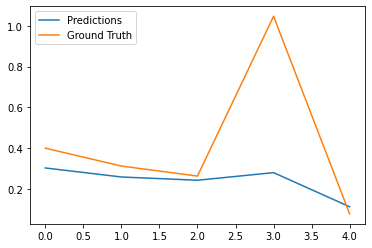

In [62]:
predictions = tf.stack([particle(X_test) for particle in particles])
predictions = tf.reduce_mean(predictions, axis=0)

plt.plot(predictions.numpy())
plt.plot(y_test)
plt.legend(['Predictions', 'Ground Truth'], loc='upper left')

plt.show()